In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [2]:
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [3]:
total_score_df = delivery.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()
total_score_df = total_score_df[total_score_df['inning'] == 1]
match_df = match.merge(total_score_df[['match_id', 'total_runs']], left_on='id', right_on='match_id')
teams = [
    'Sunrisers Hyderabad', 'Mumbai Indians', 'Royal Challengers Bangalore',
    'Kolkata Knight Riders', 'Kings XI Punjab', 'Chennai Super Kings',
    'Rajasthan Royals', 'Delhi Capitals'
]
match_df['team1'] = match_df['team1'].replace({'Delhi Daredevils': 'Delhi Capitals', 'Deccan Chargers': 'Sunrisers Hyderabad'})
match_df['team2'] = match_df['team2'].replace({'Delhi Daredevils': 'Delhi Capitals', 'Deccan Chargers': 'Sunrisers Hyderabad'})
match_df = match_df[(match_df['team1'].isin(teams)) & (match_df['team2'].isin(teams)) & (match_df['dl_applied'] == 0)]
match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]
delivery_df = match_df.merge(delivery, on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [4]:
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']
delivery_df['balls_left'] = 120 - (delivery_df['over'] * 6 + delivery_df['ball'])
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0").apply(lambda x: 0 if x == "0" else 1).astype(int)
delivery_df['cumulative_wickets'] = delivery_df.groupby('match_id')['player_dismissed'].cumsum()
delivery_df['wickets'] = 10 - delivery_df['cumulative_wickets']
delivery_df['crr'] = (delivery_df['current_score'] * 6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']

In [5]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0
delivery_df['result'] = delivery_df.apply(result, axis=1)

In [6]:
final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr', 'result']]
final_df = final_df.sample(final_df.shape[0]) 
final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] != 0]

In [7]:
X = final_df.drop('result', axis=1)
y = final_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_train_encoded = ohe.fit_transform(X_train[['batting_team', 'bowling_team', 'city']])
X_test_encoded = ohe.transform(X_test[['batting_team', 'bowling_team', 'city']])

In [9]:
X_train_final = np.concatenate([X_train_encoded, X_train[['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']].values], axis=1)
X_test_final = np.concatenate([X_test_encoded, X_test[['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']].values], axis=1)

In [10]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_final, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [11]:
y_pred = best_model.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9967685282753775
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6761
           1       1.00      1.00      1.00      7474

    accuracy                           1.00     14235
   macro avg       1.00      1.00      1.00     14235
weighted avg       1.00      1.00      1.00     14235



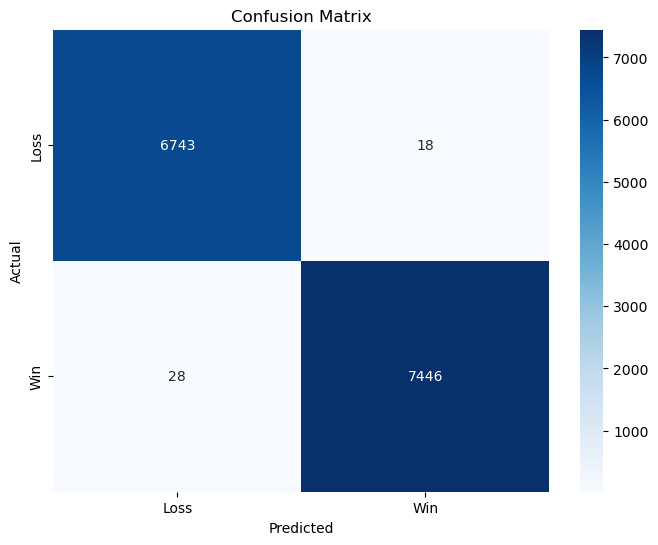

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [13]:
import joblib

In [14]:
joblib.dump(best_model, 'best_rf_model.joblib')

['best_rf_model.joblib']

In [15]:
joblib.dump(ohe, 'ohe.joblib')

['ohe.joblib']